データセットとデータローダー
===================

サンプルデータを処理するのはとても大変なのでpytorchのライブラリを上手に使う．

データセットのコードは訓練コードとは切り離すのが一般的．

Datasetの読み込み
-------------------

TorchVisionから[Fashion-MNIST](https://research.zalando.com/welcome/mission/research-projects/fashion-mnist/)をロードする例を紹介する．

余談だがMNISTは機械学習の比較的簡単なタスクであるため研究レベルではあまり使われない

今回はGoogle Colabでも簡単に動くので採用している

Fashion-MNISTは、60,000個の訓練データと10,000個のテストデータから構成された、Zalandoの記事画像のデータセット．

各サンプルは、28×28のグレースケール画像と、10クラスのうちの1つのラベルから構成されている．

In [1]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda
import matplotlib.pyplot as plt

[FashionMNIST Dataset](https://pytorch.org/docs/stable/torchvision/datasets.html#fashion-mnist)を読み込む際には、以下のパラメータを使用する．

これはよく使う．

- ``root`` ：訓練/テストデータが格納されているパスを指定
- ``train`` ：訓練データまたはテストデータセットを指定
- ``download=True``：``root`` にデータが存在しない場合は、インターネットからデータをダウンロードを指定
- ``transform`` と ``target_transform``：特徴量とラベルの変換を指定

通常transformのところにはもっと多くの変換を盛り込むことが多い．

後述する.

In [2]:
train_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

100%|██████████| 26.4M/26.4M [00:03<00:00, 7.70MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 128kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 2.39MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 8.27MB/s]


データセットの反復処理と可視化
-----------------

Datasetの特定indexを指定する際には、リスト操作と同様に、``training_data[index]``と記載．

``matplotlib``を使用し、訓練データのいくつかのサンプルを可視化する．



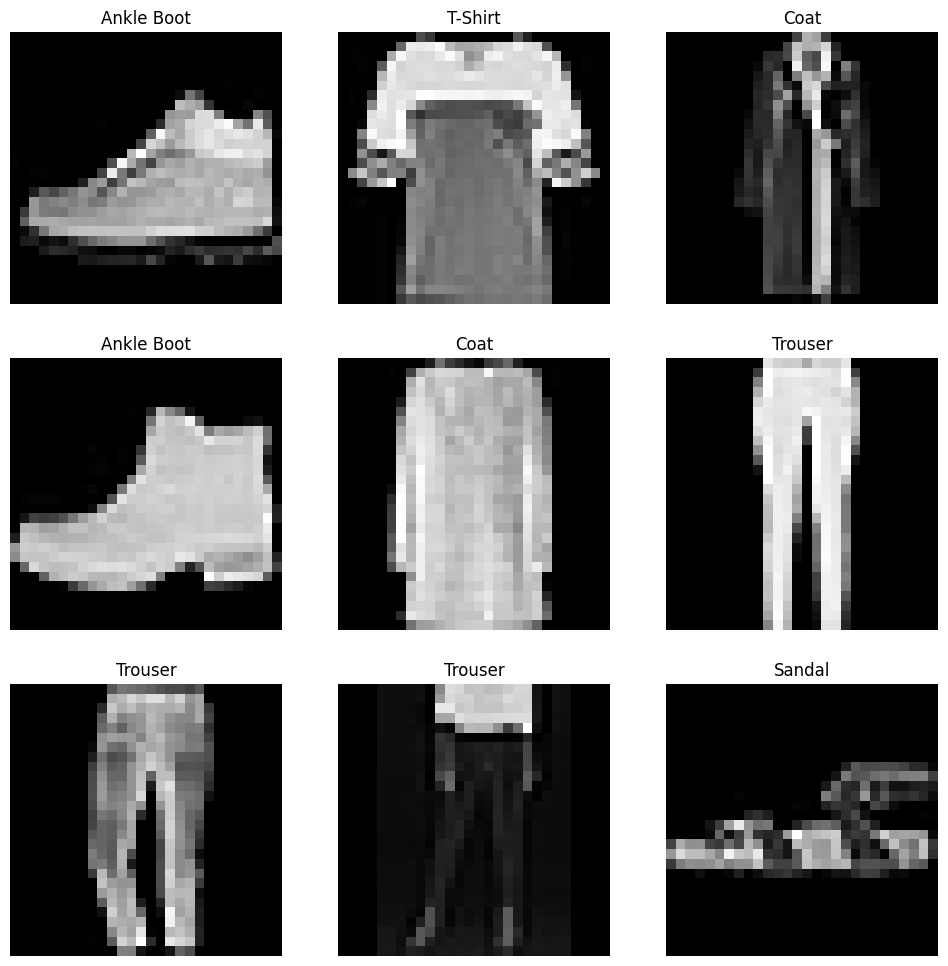

In [3]:
labels_map = {                                                 #各写真は数字で表現されているので見やすくするために対応づけしている
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(12, 12))                            #画像のサイズ
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()#データのサンプリング
    img, label = train_data[sample_idx]                        #データセットにアクセス画像をラベルを取得
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

DataLoaderの使用方法
-------------------------------------------------

``Dataset``を使用することで1つのサンプルの、データとラベルを取り出せる．

ですが、モデルの訓練時にはミニバッチ（"minibatches"）単位でデータを扱いたく、また各epochでデータはshuffleされる必要あり（訓練データへの過学習を防ぐ目的）．

加えて、Pythonの ``multiprocessing``を使用し、複数データの取り出しを高速化したい．

``DataLoader``は上記に示した複雑な処理を簡単に実行できるようにしてくれるAPIになる.


In [4]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_data, batch_size=64, shuffle=True,num_workers = 2)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True,num_workers = 2)

``num_workers``はミニバッチを作成する際の並列実行数を表していて，論理スレッド数分の高速化が期待できる．

大体2とそれ以上でそこまで性能は変わらない

また，論理スレッドの数に依存しているのでそれ以上の数は指定できない．

DataLoaderを用いた繰り返し処理
--------------------------

データセットを ``Dataloader`` に読み込ませ、必要に応じてデータセットを反復処理することができる．

今回``shuffle=True``と指定しているので、データセットのデータを全て取り出したら、データの順番は再びシャッフルされる．



Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


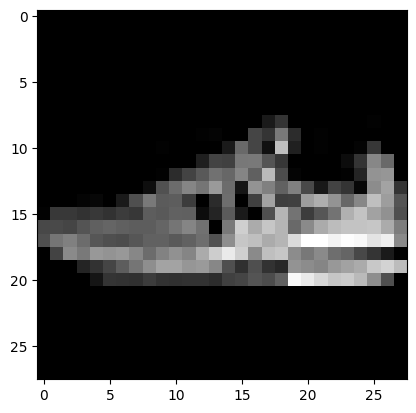

Label: 7


In [5]:
# Display image and label.
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

Transforms
===================
常に学習に適したデータセットが渡されるわけでもないので自分らでデータを適切に処理する必要がある．

データ拡張によって変換された画像を新たな画像と捉えることでデータの水増しと読んだりもする

また，機械学習では一般にデータの数が多いほど，訓練損失は期待損失をうまく近似することができるためこの水増しは大きな意味を持つ．


In [6]:
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda

ds = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y), value=1))
)

FashionMNISTデータセットの特徴量はPIL形式の画像であり、ラベルはint型で渡される．

実際の訓練では、正規化された特徴量テンソルと、one-hotエンコーディングされたラベルのテンソルが必要になる

これらのデータを作るために、``ToTensor`` と ``Lambda``を使用する．

ToTensor()
-------------------------------

[`ToTensor`](https://pytorch.org/docs/stable/torchvision/transforms.html#torchvision.transforms.ToTensor)はPIL形式の画像、もしくはNumpyの``ndarray``を、``FloatTensor``に変換する．


加えて、画像の場合にはピクセルごとの値を [0., 1.]の範囲に変換する．

よく使う．

Lambda Transforms
-------------------------------

Lambda transformsは、ユーザーが定義した関数を実行するPython関数．



本チュートリアルではint型のデータを、one-hotエンコーディングしたテンソルへと変換している．

<br>

最初に大きさ10のゼロテンソルを作成し（10はクラス数に対応）、[`scatter_`](https://pytorch.org/docs/stable/tensors.html#torch.Tensor.scatter_) を用いて、ラベル``y``の値のindexのみ1のワンホットエンコーディングに変換している．



In [7]:
target_transform = Lambda(lambda y: torch.zeros(
    10, dtype=torch.float).scatter_(dim=0, index=torch.tensor(y), value=1))

これらは機械学習のデータセットとして基本的な所作になるので一度できたら使いまわすことが多い．